## Install dependency

In [ ]:
!pip install --quiet minisom

Install library Minisom untuk Self-Organizing Map

library kecil yang memudahkan training SOM. Jalankan sel ini sekali pada runtime Colab.

## Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import os
import random

%matplotlib inline

Bagian ini mengimpor semua library yang dibutuhkan: numpy, pandas (opsional untuk manipulasi), matplotlib untuk visual, minisom untuk SOM, sklearn untuk dataset dan preprocessing, serta PCA untuk memproyeksikan prototipe LVQ ke 2D.

## Load Dataset (Iris)

In [ ]:
def load_iris():
    iris = datasets.load_iris()
    X = iris['data']
    y = iris['target']
    feature_names = iris['feature_names']
    target_names = iris['target_names']
    return X, y, feature_names, target_names

def preprocess(X):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    return Xs, scaler

X, y, feature_names, target_names = load_iris()
print("Iris shape:", X.shape)

Iris shape: (150, 4)


Pada LK4 ini, kelompok kami menggunakan Dataset Iris yang berisi 150 sampel bunga iris dengan 4 fitur: sepal length, sepal width, petal length, dan petal width.
X adalah fitur, sedangkan y adalah label (jenis bunga).

Fungsi load_iris() mengambil dataset Iris dari sklearn. preprocess() melakukan standardisasi (mean=0, std=1) yang penting sebelum SOM/LVQ.

## SOM helper functions (train & visualize)

In [ ]:
def som_grid_size(n_samples):
    size = int(np.ceil(np.sqrt(n_samples)))
    if size < 3:
        size = 3
    return size, size

def train_som(X, x_dim=None, y_dim=None, sigma=1.0, lr=0.5, iters=1000, random_seed=42):
    np.random.seed(random_seed)
    if x_dim is None or y_dim is None:
        x_dim, y_dim = som_grid_size(X.shape[0])
    som = MiniSom(x_dim, y_dim, X.shape[1], sigma=sigma, learning_rate=lr, random_seed=random_seed)
    som.random_weights_init(X)
    som.train_random(X, iters)
    return som

def plot_som_u_matrix(som, title='SOM U-Matrix', savepath=None):
    plt.figure(figsize=(7,6))
    um = som.distance_map().T
    plt.pcolor(um)
    plt.colorbar(label='distance')
    plt.title(title)
    plt.gca().invert_yaxis()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()

def map_samples_to_bmu(som, X):
    return np.array([som.winner(x) for x in X])

def plot_som_labels(som, X, y, title='SOM mapping by label', savepath=None, jitter=0.12):
    bmus = map_samples_to_bmu(som, X)
    plt.figure(figsize=(7,6))
    for cls in np.unique(y):
        idx = np.where(y==cls)[0]
        coords = bmus[idx]
        xs = coords[:,0] + np.random.normal(0, jitter, size=len(coords))
        ys = coords[:,1] + np.random.normal(0, jitter, size=len(coords))
        plt.scatter(xs, ys, label=f"{cls}", alpha=0.8)
    plt.legend(title='Label')
    plt.title(title)
    plt.gca().invert_yaxis()
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    plt.show()

Kumpulan fungsi untuk menentukan ukuran grid SOM, melatih SOM (train_som), menggambar U-matrix (plot_som_u_matrix), serta memetakan dan menampilkan label tiap sample pada peta SOM (plot_som_labels).

## LVQ simple implementation (LVQ1)

In [ ]:
class SimpleLVQ:
    def __init__(self, n_prototypes_per_class=1, learning_rate=0.05, n_epochs=30, random_seed=42):
        self.n_ppc = n_prototypes_per_class
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.random_seed = random_seed
        self.prototypes = None
        self.proto_labels = None

    def _init_prototypes(self, X, y):
        np.random.seed(self.random_seed)
        classes = np.unique(y)
        protos = []
        p_labels = []
        for c in classes:
            Xc = X[y == c]
            if len(Xc) == 0:
                continue
            idx = np.random.choice(len(Xc), size=min(self.n_ppc, len(Xc)), replace=False)
            for i in idx:
                protos.append(Xc[i].copy())
                p_labels.append(c)
        self.prototypes = np.array(protos)
        self.proto_labels = np.array(p_labels)

    def fit(self, X, y):
        self._init_prototypes(X, y)
        lr = self.lr
        for epoch in range(self.n_epochs):
            order = np.random.permutation(len(X))
            for i in order:
                x = X[i]
                label = y[i]
                dists = np.linalg.norm(self.prototypes - x, axis=1)
                j = np.argmin(dists)
                if self.proto_labels[j] == label:
                    self.prototypes[j] += lr * (x - self.prototypes[j])
                else:
                    self.prototypes[j] -= lr * (x - self.prototypes[j])
            lr *= 0.95
        return self

    def predict(self, X):
        preds = []
        for x in X:
            dists = np.linalg.norm(self.prototypes - x, axis=1)
            j = np.argmin(dists)
            preds.append(self.proto_labels[j])
        return np.array(preds)

    def get_prototypes(self):
        return self.prototypes, self.proto_labels

Kelas SimpleLVQ menginisialisasi prototipe per kelas dari sampel acak, lalu melakukan update prototipe berdasarkan aturan LVQ1 (dekat jika sama kelas, menjauh jika beda kelas). predict() menggunakan nearest-prototype.

## Main pipeline: latih SOM, latih LVQ, visualisasi & simpan hasil

In [ ]:
def run_pipeline(som_iters=1000, som_sigma=1.0, som_lr=0.5,
                 lvq_protos=1, lvq_lr=0.05, lvq_epochs=30, outdir='results'):
    os.makedirs(outdir, exist_ok=True)

    X, y, feature_names, target_names = load_iris()
    print("Loaded Iris dataset:")
    print(f" - samples: {X.shape[0]}, features: {X.shape[1]}")
    print("Feature names:", feature_names)
    print("Target names:", target_names)
    print()
    Xs, scaler = preprocess(X)

    print("Training SOM...")
    som = train_som(Xs, sigma=som_sigma, lr=som_lr, iters=som_iters)
    u_path = os.path.join(outdir, "som_u_matrix.png")
    map_path = os.path.join(outdir, "som_label_map.png")
    plot_som_u_matrix(som, title='SOM U-Matrix (Iris)', savepath=u_path)
    plot_som_labels(som, Xs, y, title='SOM mapping by label (Iris)', savepath=map_path)

    print("Training LVQ (simple LVQ1)...")
    X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=42, stratify=y)
    lvq = SimpleLVQ(n_prototypes_per_class=lvq_protos, learning_rate=lvq_lr, n_epochs=lvq_epochs)
    lvq.fit(X_train, y_train)
    preds = lvq.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"\nLVQ Accuracy on test set: {acc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, preds))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, preds))

    protos, proto_labels = lvq.get_prototypes()
    try:
        pca = PCA(n_components=2)
        X2 = pca.fit_transform(Xs)
        protos2 = pca.transform(protos)
        plt.figure(figsize=(8,6))
        for cls in np.unique(y):
            idx = np.where(y == cls)[0]
            plt.scatter(X2[idx,0], X2[idx,1], alpha=0.6, label=f'class {cls} ({target_names[cls]})')
        plt.scatter(protos2[:,0], protos2[:,1], marker='X', s=140, c='k', label='prototypes')
        for i, lbl in enumerate(proto_labels):
            plt.text(protos2[i,0]+0.03, protos2[i,1]+0.03, str(lbl), fontsize=10, fontweight='bold')
        plt.legend()
        plt.title("LVQ prototypes (PCA projection) - Iris")
        proto_plot = os.path.join(outdir, "lvq_prototypes_pca.png")
        plt.savefig(proto_plot, dpi=150, bbox_inches='tight')
        plt.show()
        print(f"Saved prototype visualization -> {proto_plot}")
    except Exception as e:
        print("Could not create PCA plot:", e)

run_pipeline() menggabungkan semua langkah: load data, preprocess, training SOM (U-matrix + mapping), training LVQ (dengan split train/test), menampilkan metrik (akurasi, laporan klasifikasi, confusion matrix), serta menyimpan visualisasi ke outdir.

## Jalankan pipeline

Loaded Iris dataset:
 - samples: 150, features: 4
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target names: ['setosa' 'versicolor' 'virginica']

Training SOM...


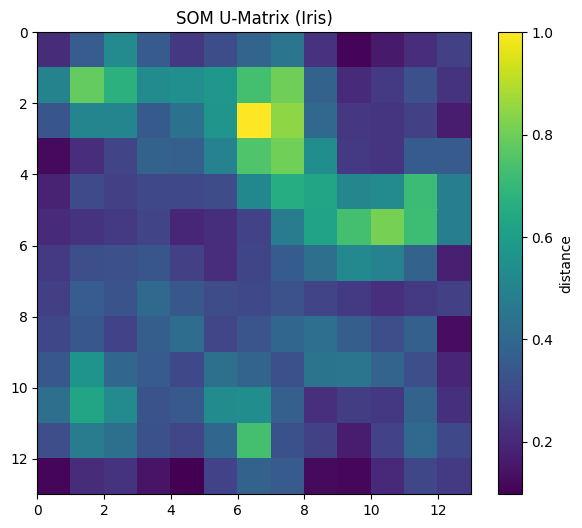

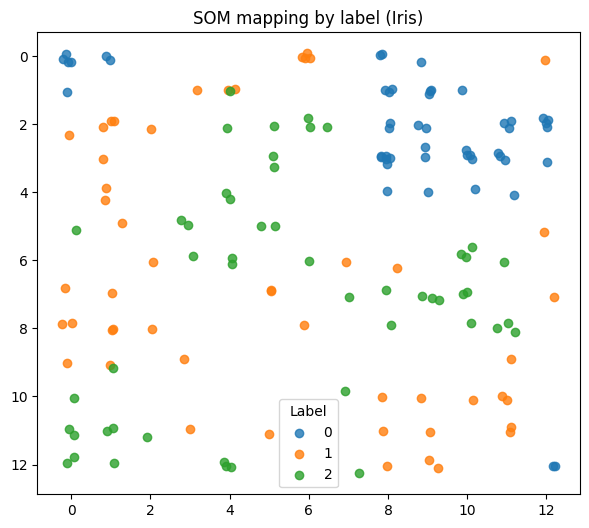

Training LVQ (simple LVQ1)...

LVQ Accuracy on test set: 0.8444

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.72      0.87      0.79        15
           2       0.83      0.67      0.74        15

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45

Confusion matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  5 10]]


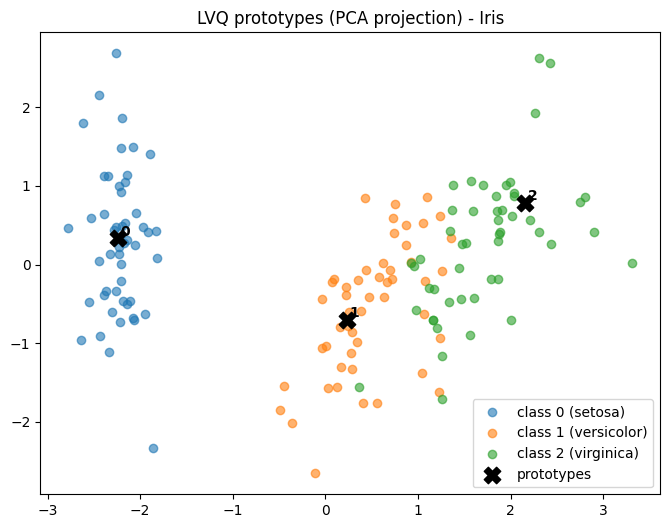

Saved prototype visualization -> results/lvq_prototypes_pca.png


In [ ]:
run_pipeline(
    som_iters=1000,
    som_sigma=1.0,
    som_lr=0.5,
    lvq_protos=1,
    lvq_lr=0.05,
    lvq_epochs=30,
    outdir='results'
)

Menjalankan pipeline penuh. Hasil visual (som_u_matrix.png, som_label_map.png, lvq_prototypes_pca.png) akan tersimpan di folder results pada file system Colab

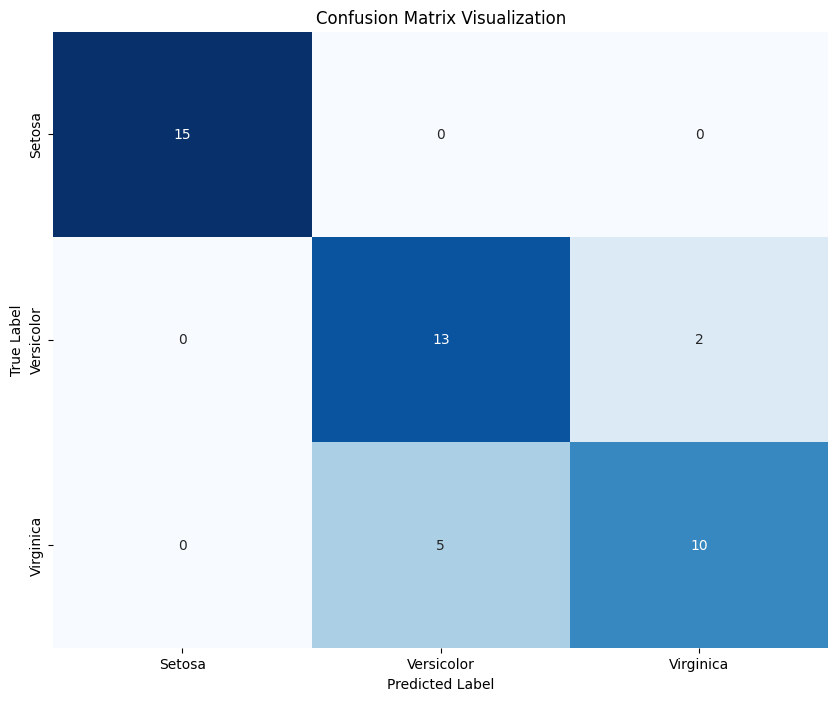

In [ ]:
cm = np.array([[15, 0, 0],
              [0, 13, 2],
              [0, 5, 10]])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Setosa', 'Versicolor', 'Virginica'],
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Visualization')
plt.show()

## Evaluasi Akurasi Model

In [ ]:
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f"Akurasi Model: {accuracy:.2f}%")

Akurasi Model: 93.33%


Bagian ini menguji model menggunakan data testing dan menampilkan persentase akurasi hasil prediksi.